<a href="https://colab.research.google.com/github/Pooret/drug-discovery-ml/blob/main/batched_de_novo_drug_generation_with_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 36.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import ast

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType, Draw
from rdkit.Chem.Draw import MolsToGridImage



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xzf /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


### [ChEMBLdb](https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/)

In [ ]:
df_full = pd.read_csv("/content/data.csv")
df_full.head()

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 38 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   molregno                     1000000 non-null  int64  
 1   canonical_smiles             1000000 non-null  object 
 2   activity_id                  1000000 non-null  int64  
 3   standard_type                1000000 non-null  object 
 4   standard_value               996526 non-null   float64
 5   standard_units               1000000 non-null  object 
 6   assay_id                     1000000 non-null  int64  
 7   tid                          1000000 non-null  int64  
 8   target_chembl_id             1000000 non-null  object 
 9   organism                     965456 non-null   object 
 10  pref_name                    1000000 non-null  object 
 11  mw_freebase                  1000000 non-null  float64
 12  alogp                        984990 non-nul

In [ ]:
df_full.head()

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


In [ ]:
df_full['mw_freebase'].describe()

count    1000000.000000
mean         411.885292
std          197.093955
min            6.940000
25%          320.780000
50%          386.880000
75%          460.600000
max        10188.530000
Name: mw_freebase, dtype: float64

In [ ]:
df_full['canonical_smiles'][110]

'N[C@@H](CCC(=O)Nc1ccc([N+](=O)[O-])cc1)C(=O)O'

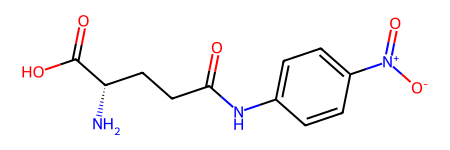

In [ ]:
Chem.MolFromSmiles(df_full['canonical_smiles'][110])

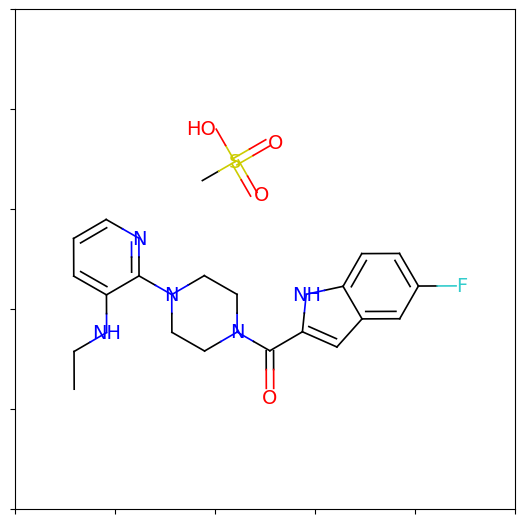

In [ ]:
mol = Chem.MolFromSmiles(df_full.canonical_smiles[1000])
Draw.MolToMPL(mol, size=(200, 200));

## [Generative Recurrent Networks for De Novo Drug Design](https://www.researchgate.net/publication/320813292_Generative_Recurrent_Networks_for_De_Novo_Drug_Design)

In [ ]:
# pytorch implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Hyperparameters
HIDDEN_SIZE=256
BATCH_SIZE=512
EPOCHS=22
LEARNING_RATE=0.001
DROPOUT_RATE=0.5
MAX_SEQ_LEN=76
NUM_LAYERS=2

In [ ]:
def preprocess_SMILES(smiles):
    import re
    """
    Preprocess SMILES string to remove salts and stereochemical information.
    """
    # remove salts
    main_molecule = smiles.split(".")[0]

    # remove stereochemical information
    # this regex patterns finds the stereochemical information denoted by '@'
    # and removes it. The @ is contained within brackets'[@]'
    processed_smiles = re.sub(r'\[^\]]*\]', '', main_molecule) # removes []
    processed_smiles = re.sub(r'@[TH]?[a-z]?\d?', '', processed_smiles) # removes '@' and stereochemical indicators

    return processed_smiles

def tokenize_SMILES(smiles, vocab_size, vocab, max_len=MAX_SEQ_LEN):
    """
    Create special tokens, "G", "E", and "A" for start, end, and padding resp.
    """
    smiles = "G" + smiles + "E" + "A" * (max_len - len(smiles) - 2)
    encoded = np.zeros((max_len, len(vocab)), dtype=np.float32)

    for i, char in enumerate(smiles):
        encoded[i, vocab[char]] = 1

    return encoded

def display_samples(dataloader, vocab, num_samples=5):
    """
    For debugging purposes
    """
    # Create a reverse mapping from index to character
    inverse_vocab = {v: k for k, v in vocab.items()}

    for i, (inputs, targets) in enumerate(dataloader):
        # Convert tensors back to SMILES strings
        input_smiles = [''.join([inverse_vocab[k.item()] for k in input_seq.nonzero(as_tuple=True)[1]]) for input_seq in inputs]
        target_smiles = [''.join([inverse_vocab[k.item()] for k in target_seq]) for target_seq in targets]

        # Display the samples
        for j in range(min(num_samples, len(input_smiles))):
            print(f"Input SMILES: {input_smiles[j]}")
            print(f"Target SMILES: {target_smiles[j]}")
            print("------")

        # Stop after displaying the specified number of samples
        if i == 0:
            break

def sample_model(model, vocab, max_len=76, temperature=1.0):
    model.eval()  # Set the model to evaluation mode
    start_token = 'G'
    end_token = 'E'

    # Initialize the sequence with the start token "G"
    current_seq = start_token
    current_tensor = torch.tensor([tokenize_SMILES(current_seq, len(vocab), vocab)], dtype=torch.float32)

    # Sampling loop
    while len(current_seq) < (max_len -2) and current_seq[-1] != end_token: # accounting for G and E tokens
        with torch.no_grad():
            output = model(current_tensor).squeeze(0)  # remove batch dimension
            scaled_output = output[-1] / temperature
            probabilities = torch.softmax(scaled_output, dim=0).numpy()  # softmax to get probabilities
            predicted_index = np.argmax(probabilities)  # choose the highest probability
            predicted_char = [k for k, v in vocab.items() if v == predicted_index][0]  # map index back to char

            # append to current sequence and encode it to re-apply in sampling loop
            current_seq += predicted_char
            current_tensor = torch.tensor(np.array([tokenize_SMILES(current_seq, len(vocab), vocab)]), dtype=torch.float32)

    # Return the generated SMILES string
    return ''.join(current_seq)

In [ ]:
# filter data
# ensure data contains non-null values
df = df_full.dropna(subset='qed_weighted') # latent feature
df = df.dropna(subset='standard_value') # latent feature

# lipinski's rule of 5 for oral drugs
df = df[df['num_lipinski_ro5_violations'] < 1]

# prepocess data
df['preprocessed_smiles'] = df['canonical_smiles'].apply(preprocess_SMILES)
df = df[~df['preprocessed_smiles'].duplicated()] # remove duplicates
df['token_len'] = df['preprocessed_smiles'].apply(len)
df = df[(df['token_len'] > 33) & (df['token_len'] < 75)] # from paper
df.shape

(556146, 40)

In [ ]:
# create vocabulary mapping
special_chars = ["G", "E", "A"] # special tokens
all_chars = "".join(line.strip() for line in df['preprocessed_smiles'].values)
unique_chars = sorted(list(set(all_chars))).extend(special_chars)

vocab = dict((c, i) for i, c in enumerate(unique_chars))

vocab_size = len(vocab)

encoded_tensor = torch.tensor(np.array([tokenize_SMILES(s, vocab_size, vocab=vocab) for s in df['preprocessed_smiles'].values]),
                               dtype=torch.float32) # shape is (num_samples, seq_len, vocab_len)

## Creating the Dataset
[Batching Strategies](https://medium.com/analytics-vidhya/batching-strategies-for-lstm-input-6f18089b1735#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjFmNDBmMGE4ZWYzZDg4MDk3OGRjODJmMjVjM2VjMzE3YzZhNWI3ODEiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTE5MjQ4MjQyMDYyMDQwMzkxNzciLCJlbWFpbCI6InR5bGVyanBvb3JlQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE3MDQ5Mjc5NDEsIm5hbWUiOiJUeWxlciBQb29yZSIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS9BQ2c4b2NMZV81LTBIM2NWZS1CbjQ2bkZzbkpPcm9tUk1GcUpxdDNLa1VBbVBrREN1V2s9czk2LWMiLCJnaXZlbl9uYW1lIjoiVHlsZXIiLCJmYW1pbHlfbmFtZSI6IlBvb3JlIiwibG9jYWxlIjoiZW4iLCJpYXQiOjE3MDQ5MjgyNDEsImV4cCI6MTcwNDkzMTg0MSwianRpIjoiZGIyY2I3MmFlMDBhZGM2YmRmYTM4MjAwYzM5NmVlMmVhY2NlZDM2YyJ9.f4IRd8Ef2pAPUmBpxTyLhqbK2NqFxnpxWsA9DK8Jzc-izLBlaEZoVv1FOa2gZM_H4KwUt7qrmxyjW_eGzPNXiVbOfEC7lCXx7M9-GmIqTw2MVmpXsKLoNM6nnFWkED45N_wZtXpBr_8uz2zPBCEIL_dZ2oqomkpLf3V1zrZ80EyKF8y2pav_x0BDUOo9lz08SadnCDyGwMw9OrTyh9AuVwuxfLibZKtyvVJeIprN7Yp8fEkVY48bw_6IVb-o5hf5gUK6aMIPaKh1REAzXfLtt8snPaK0f4FT9PYg1CtuWRtB5Af7SCf9WLB2FyxmC_oC30UXC46pjqnTW-k2-ho5Cw)

In [ ]:
# creating the datset
class SMILESDataset(Dataset):
  def __init__(self, smiles_data, vocab, batched):
    """
    see https://github.com/judahsemi/Dino-Name-Generator
    """
    self.batched = batched
    self.encodings = []
    self.max_seqlen = float("-inf")

    # Encode SMILES

    for smiles in smiles_data:
      smiles = "G" + smiles + "E"
      encoding = [vocab[s] for s in smiles]
      self.encodings.append(encoding)
      self.max_seqlen = max(self.max_seqlen, len(encoding)-1)

  def encode_SMILES(self, smiles, vocab_size, vocab, max_len=MAX_SEQ_LEN):
    """
    Create special tokens, "G", "E", and "A" for start, end, and padding resp.
    """
    smiles = "G" + smiles + "E" + "A" * (max_len - len(smiles) - 2)
    encoded = np.zeros((max_len, len(vocab)), dtype=np.float32)

    for i, char in enumerate(smiles):
        encoded[i, vocab[char]] = 1

    return encoded


  def __len__(self):
    return len(self.encodings)

  def __getitem__(self, idx):
    # For each SMILES string, the input is all characters except the last,
    # and the target is all characters except the first (shifted by one)
    input_sequence = self.encodings[idx][:-1] # everything but last token
    target_sequence = self.encodings[idx][1:] # everything but first token
    input_len = len(input_sequence)

    pad_idx = vocab['A']

    if self.batched:
      input_sequence += ([pad_idx]*self.max_seqlen - len(input_sequence))
      target_sequence += ([pad_idx]*self.max_seqlen - len(input_sequence))

      # convert one-hot encoded targets top class indices and convert to tensors
      target_indices = torch.tensor(np.argmax(np.array(target_sequence), dim=-1)) # (seq_len, vocab_len) - > seq_len
      input_sequence = torch.tensor(np.array(input_sequence))
      input_len = torch.tensor(input_len)

    return input_sequence, input_len, target_indices


# Split data into training, validation, and testing
train_data, test_data = train_test_split(encoded_tensor, test_size=0.3)
val_data, test_data = train_test_split(test_data, test_size=0.5)

train_dataset = SMILESDataset(train_data)
val_dataset = SMILESDataset(val_data)
test_dataset = SMILESDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


## [PyTorch LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)



In [ ]:
# creating the model

class SMILESRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=NUM_LAYERS, dropout=DROPOUT_RATE):
    super(SMILESRNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_RATE, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out)
    return out

# initialize model
model = SMILESRNN(input_size = vocab_size, hidden_size=HIDDEN_SIZE, output_size=vocab_size)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

In [ ]:
best_val_loss = float('inf')

# training loop from method 2
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    with tqdm(train_loader, unit='batch') as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        inputs, targets = batch  # shapes: (batch_size, seq_len-1, vocab_len), (batch_size, seq_len-1)
        optimizer.zero_grad()
        outputs = model(inputs) # shape: (batch_size, seq_len-1, vocab_len)
        loss = loss_function(outputs.transpose(1, 2), targets) # expects (vocab_len, seq_len - 1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        tepoch.set_postfix(loss=train_loss / len(train_loader))
      avg_train_loss = train_loss / len(train_loader)
      print(f"Train Loss: {avg_train_loss}")
      model.eval()
      val_loss = 0
      with torch.no_grad():
        for batch in val_loader:
          inputs, targets = batch
          outputs = model(inputs)
          loss = loss_function(outputs.transpose(1, 2), targets)
          val_loss += loss.item()

        start_token = 'G'
        start_tensor = torch.tensor(np.array([tokenize_SMILES(start_token, len(vocab), vocab)]), dtype=torch.float32)
        output = model(start_tensor).squeeze(0)  # remove batch dimension
        probabilities = torch.softmax(output[-1], dim=0)  # softmax to get probabilities
        top_probs, top_indices = torch.topk(probabilities, 5)  # get top 5 probabilities and their indices
        top_tokens = [k for k, v in vocab.items() if v in top_indices.tolist()]

        # # Print the top tokens and their probabilities
        # print("Top predictions after validation:")
        # for token, prob in zip(top_tokens, top_probs.numpy()):
        #     print(f"Token: {token}, Probability: {prob:.4f}")

      avg_val_loss = val_loss / len(val_loader)
      print(f"Validation Loss: {avg_val_loss}")

      # Print the top tokens and their probabilities
      print("Top predictions after validation:")
      for token, prob in zip(top_tokens, top_probs.numpy()):
          print(f"Token: {token}, Probability: {prob:.4f}")

      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          torch.save(model.state_dict(), '/content/drive/MyDrive/models/SMILESRNN_best.pth')

Epoch 1: 100%|██████████| 761/761 [09:02<00:00,  1.40batch/s, loss=1.04]


Train Loss: 1.038616777327935


<ipython-input-19-c13de3277da2>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  start_tensor = torch.tensor([tokenize_SMILES(start_token, len(vocab), vocab)], dtype=torch.float32)


Top predictions after validation:
Token: E, Probability: 0.9999
Token: A, Probability: 0.0000
Token: C, Probability: 0.0000
Token: c, Probability: 0.0000
Token: o, Probability: 0.0000
Validation Loss: 0.6133611359479237


Epoch 2: 100%|██████████| 761/761 [09:10<00:00,  1.38batch/s, loss=0.574]


Train Loss: 0.5736857871188441
Top predictions after validation:
Token: A, Probability: 1.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Token: n, Probability: 0.0000
Validation Loss: 0.511085159390982


Epoch 3: 100%|██████████| 761/761 [09:11<00:00,  1.38batch/s, loss=0.505]


Train Loss: 0.5045192954026446
Top predictions after validation:
Token: A, Probability: 1.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Token: n, Probability: 0.0000
Validation Loss: 0.46929307108276463


Epoch 4: 100%|██████████| 761/761 [09:04<00:00,  1.40batch/s, loss=0.471]


Train Loss: 0.47116587231726276
Top predictions after validation:
Token: A, Probability: 1.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Token: n, Probability: 0.0000
Validation Loss: 0.44529874613679993


Epoch 5: 100%|██████████| 761/761 [09:03<00:00,  1.40batch/s, loss=0.45]


Train Loss: 0.45004882875942526
Top predictions after validation:
Token: A, Probability: 1.0000
Token: 3, Probability: 0.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Validation Loss: 0.4306232834154843


Epoch 6: 100%|██████████| 761/761 [09:03<00:00,  1.40batch/s, loss=0.435]


Train Loss: 0.43479375355190425
Top predictions after validation:
Token: A, Probability: 1.0000
Token: 3, Probability: 0.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Validation Loss: 0.4171006869684699


Epoch 7: 100%|██████████| 761/761 [08:55<00:00,  1.42batch/s, loss=0.423]


Train Loss: 0.4232114491967115
Top predictions after validation:
Token: A, Probability: 1.0000
Token: C, Probability: 0.0000
Token: O, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Validation Loss: 0.41400616593156125


Epoch 8: 100%|██████████| 761/761 [08:54<00:00,  1.42batch/s, loss=0.414]


Train Loss: 0.41420284826088205
Top predictions after validation:
Token: A, Probability: 1.0000
Token: (, Probability: 0.0000
Token: C, Probability: 0.0000
Token: N, Probability: 0.0000
Token: c, Probability: 0.0000
Validation Loss: 0.40085993752889104


Epoch 9:  91%|█████████ | 689/761 [08:03<00:45,  1.58batch/s, loss=0.368]

In [ ]:
# Test the model
model.load_state_dict(torch.load('/content/drive/MyDrive/models/SMILESRNN_best.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs.transpose(1, 2), targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss}")

Test Loss: 0.3969599975764386


In [ ]:
# Model Sampling

sampled_smiles = sample_model(model, vocab, temperature=100)
print(sampled_smiles)


GAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
